# Deploy modern Foundation Models on SageMaker AI

In this notebook we show how to deploy modern Foundation Models on SageMaker AI endpoints.

We will start with simple use-cases (deploying JumpStart Model) and then move to more advanced use-cases - deploying model from S3, using Inference Component enabled endpoints and custom containers.

## Setup

- Fetch and import dependencies
- Initialize SageMaker environment and required clients to access AWS services

In [ ]:
%pip install sagemaker --upgrade --quiet --no-warn-conflicts

In [ ]:
import json
import sagemaker
import boto3

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()

sm_client = boto3.client("sagemaker")  # client to intreract with SageMaker
smr_client = boto3.client("sagemaker-runtime")  # client to intreract with SageMaker Endpoints

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
print(f"sagemaker version: {sagemaker.__version__}")

### Helper functions

In [ ]:
import io
import json
import time
import boto3
from IPython.display import clear_output

class LineIterator:
    def __init__(self, stream):
        self.byte_iterator = iter(stream)
        self.buffer = io.BytesIO()
        self.read_pos = 0

    def __iter__(self):
        return self

    def __next__(self):
        while True:
            self.buffer.seek(self.read_pos)
            line = self.buffer.readline()
            if line and line[-1] == ord("\n"):
                self.read_pos += len(line)
                return line[:-1]
            try:
                chunk = next(self.byte_iterator)
            except StopIteration:
                if self.read_pos < self.buffer.getbuffer().nbytes:
                    continue
                raise
            if "PayloadPart" not in chunk:
                print("Unknown event type:" + chunk)
                continue
            self.buffer.seek(0, io.SEEK_END)
            self.buffer.write(chunk["PayloadPart"]["Bytes"])

def stream_response(endpoint_name, inputs, max_tokens=8189, temperature=0.7, top_p=0.9):
    body = {
      "messages": [
        {"role": "user", "content": [{"type": "text", "text": inputs}]}
        ],
        "max_tokens": max_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "stream": True,
    }

    resp = smr_client.invoke_endpoint_with_response_stream(
        EndpointName=endpoint_name,
        Body=json.dumps(body),
        ContentType="application/json",
    )

    event_stream = resp["Body"]
    start_json = b"{"
    full_response = ""
    start_time = time.time()
    token_count = 0

    for line in LineIterator(event_stream):
        if line != b"" and start_json in line:
            data = json.loads(line[line.find(start_json):].decode("utf-8"))
            token_text = data['choices'][0]['delta'].get('content', '')
            full_response += token_text
            token_count += 1

            # Calculate tokens per second
            elapsed_time = time.time() - start_time
            tps = token_count / elapsed_time if elapsed_time > 0 else 0

            # Clear the output and reprint everything
            clear_output(wait=True)
            print(full_response)
            print(f"\nTokens per Second: {tps:.2f}", end="")

    print("\n") # Add a newline after response is complete

    return full_response

## 1. Deployment (simple)

In this section, we will:
- Deploy a `Llama-3.2-3B-Instruct` from SageMaker JumpStart using SageMaker Python SDK
- Deploy a `Qwen3-4B-Thinking-2507` model from HuggingFace hub using managed LMI container

### Option 1.1. Deploy `Meta-Llama-3.2-3B-Instruct` from JumpStart 

This is easiest way to deploy a model on SageMaker AI. All models hosted on JumpStart contains metadata that define model weights location, serving container and all serving environment variables.

In [ ]:
from sagemaker.jumpstart.model import JumpStartModel

accept_eula = False  # Change to True to agree to term and conditions and accept EULA

model_id, model_version = "meta-textgeneration-llama-3-2-3b-instruct", "1.1.7"
model_name = endpoint_name = sagemaker.utils.name_from_base("workshop-js")
instance_type = "ml.g5.2xlarge"
timeout = 600

jumpstart_model = JumpStartModel(
    model_id=model_id,
    model_version=model_version,
    name=model_name
)

jumpstart_model.deploy(
    accept_eula=accept_eula,
    instance_type=instance_type,
    initial_instance_count=1,
    container_startup_health_check_timeout=timeout,
    endpoint_name=endpoint_name,
)

llm = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

#### Inference test

In [ ]:
payload={
    "messages": [
        {"role": "user", "content": "What is Amazon SageMaker?"}
    ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

#### Cleanup

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
sess.delete_model(model_name)

### Option 1.2. Deploy `Qwen/Qwen3-4B-Thinking-2507` from HuggingFace HUB using LMI container

HuggingFace hub is a de-facto standard for hosting various models.

Large Model Inference (LMI) container is a first-party container provided by SageMaker AI team which was designed to host Foundation Models efficiently on Amazon SageMaker AI. It's powered by vLLM backend for state of the art inference performance.

In [ ]:
CONTAINER_VERSION = "0.33.0-lmi15.0.0-cu128"

inference_image = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:{CONTAINER_VERSION}"
model_name = sagemaker.utils.name_from_base("workshop-hf-lmi")
endpoint_name = model_name
instance_type = "ml.g5.2xlarge"
timeout = 600

common_env = {
    "HF_MODEL_ID": "Qwen/Qwen3-4B-Thinking-2507",
}
lmi_env = {
    "SERVING_FAIL_FAST": "true",
    "OPTION_ASYNC_MODE": "true",
    "OPTION_ROLLING_BATCH": "disable",
    "OPTION_MAX_MODEL_LEN": "16384",
    "OPTION_TENSOR_PARALLEL_DEGREE": "max",
    "OPTION_ENTRYPOINT": "djl_python.lmi_vllm.vllm_async_service",
    "OPTION_TRUST_REMOTE_CODE": "true",
}
env = common_env | lmi_env

In [ ]:
lmi_model = sagemaker.Model(
    image_uri=inference_image,
    env=env,
    role=role,
    name=model_name
)

lmi_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    container_startup_health_check_timeout=timeout,
    endpoint_name=endpoint_name,
)

llm = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

#### Inference Test

In [ ]:
payload={
    "messages": [
        {"role": "user", "content": "What is bigger 9.11 or 9.8?"}
    ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

#### Cleanup

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
sess.delete_model(model_name)

## 2. Deployment (advanced)

In this section, we will show how to use more advanced deployment scenarios:
- How to deploy a model from S3 location and update Python libraries inside the conatiner at startup
- How to deploy a ***quantized*** model on Inference Component enabled endpoint
- How to deploy a model using CloudFormation
- How to deploy a model using your own custom container

### Option 2.1: Deploy `deepseek-ai/DeepSeek-R1-Distill-Qwen-7B` from S3 (and update Python modules)

Although using deployment from HuggingFace Hub is very convinient during experimentation, in a real production deployment scenarios, the models are deployed from a customer S3 bucket.
This example demonstrate how to do this and how to update Python libraries during deployment (for example, to a newer version).

We the purpose of this workshop, we will download the model to S3 first.

#### Download the model from HF and upload to S3

In [ ]:
from huggingface_hub import snapshot_download
from pathlib import Path

local_model_path = Path("./model")
local_model_path.mkdir(exist_ok=True)
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"

model_path = snapshot_download(
    repo_id=model_name,
    local_dir=local_model_path,
)

As an example, let's update the vLLM version in the container.

In [ ]:
!echo "vllm==0.8.5" > {model_path}/requirements.txt

In [ ]:
from sagemaker.s3 import S3Uploader

s3_path = f"s3://{bucket}/workshop/model"

# upload to S3
uploaded_s3_uri = S3Uploader.upload(
    local_path=model_path,
    desired_s3_uri=s3_path
)

#### Deploy the model from S3 (Python modules will be updated)

In [ ]:
CONTAINER_VERSION = "0.33.0-lmi15.0.0-cu128"

inference_image = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:{CONTAINER_VERSION}"
model_name = sagemaker.utils.name_from_base("workshop-s3-lmi")
endpoint_name = model_name
instance_type = "ml.g5.2xlarge"
timeout = 600

common_env = {
    "HF_MODEL_ID": "/opt/ml/model",
}
lmi_env = {
    "SERVING_FAIL_FAST": "true",
    "OPTION_ASYNC_MODE": "true",
    "OPTION_ROLLING_BATCH": "disable",
    "OPTION_MAX_MODEL_LEN": "16384",
    "OPTION_TENSOR_PARALLEL_DEGREE": "max",
    "OPTION_ENTRYPOINT": "djl_python.lmi_vllm.vllm_async_service",
    "OPTION_TRUST_REMOTE_CODE": "true",
}
env = common_env | lmi_env

Please note that we use `model_data` parameter when creating a model object that points to S3 prefix with uncompressed model weights

In [ ]:
lmi_model = sagemaker.Model(
    image_uri=inference_image,
    env=env,
    role=role,
    name=model_name,
    model_data={
        'S3DataSource': {
            'S3Uri': uploaded_s3_uri + "/",
            'S3DataType': 'S3Prefix',
            'CompressionType': 'None'
        }
    },
)

lmi_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    container_startup_health_check_timeout=timeout,
    endpoint_name=endpoint_name,
)

llm = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

You should see a message below as a confirmation that all required Python modules were installed
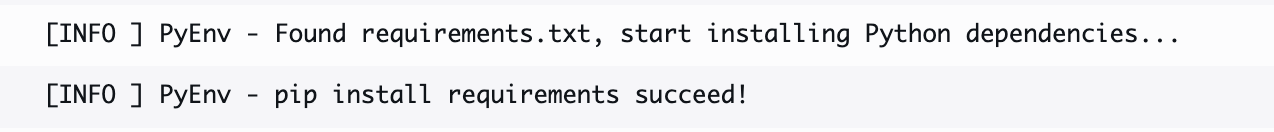

#### Inference Test

In [ ]:
payload={
    "messages": [
        {"role": "user", "content": "Name popular places to visit in London?"}
    ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

#### Cleanup

In [ ]:
!rm -rf {local_model_path}

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
sess.delete_model(model_name)

### Option 2.2: Deploy a ***quantized*** model (`Qwen/Qwen2.5-VL-7B-Instruct-AWQ`) to Inference Component endpoint

It's very common to use quantized models to reduce the GPU memoery requirements and speed up the inference. 

It's very straight-forward to deploy a quantized version on SageMaker AI, the serving backend recognize that the model weights are quantized after loading `config.json` and handles them correctly.

In this example, we will deploy a model to Inference Component enabled endpoint. Inference Components allow deployment of multiple models on the same endpoint in case of multi-GPU instance types.

In [ ]:
CONTAINER_VERSION = "0.33.0-lmi15.0.0-cu128"

inference_image = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:{CONTAINER_VERSION}"
model_name = sagemaker.utils.name_from_base("workshop-ic")
endpoint_name = model_name
instance_type = "ml.g5.2xlarge"
timeout = 600

common_env = {
    "HF_MODEL_ID": "Qwen/Qwen2.5-VL-7B-Instruct-AWQ",
}
lmi_env = {
    "SERVING_FAIL_FAST": "true",
    "OPTION_ASYNC_MODE": "true",
    "OPTION_ROLLING_BATCH": "disable",
    "OPTION_MAX_MODEL_LEN": "16384",
    "OPTION_TENSOR_PARALLEL_DEGREE": "max",
    "OPTION_ENTRYPOINT": "djl_python.lmi_vllm.vllm_async_service",
    "OPTION_TRUST_REMOTE_CODE": "true",
}
env = common_env | lmi_env

In [ ]:
from sagemaker.compute_resource_requirements.resource_requirements import ResourceRequirements

inference_component_name = f"ic-{model_name}"

lmi_model = sagemaker.Model(
    image_uri=inference_image,
    env=env,
    role=role,
    name=model_name,
)

lmi_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    container_startup_health_check_timeout=timeout,
    endpoint_name=endpoint_name,
    endpoint_type=sagemaker.enums.EndpointType.INFERENCE_COMPONENT_BASED,
    inference_component_name=inference_component_name,
    resources=ResourceRequirements(requests={"num_accelerators": 1, "memory": 1024*5, "copies": 1,}),
)

llm = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
    component_name=inference_component_name
)

In [ ]:
import base64

def image_to_base64_data_uri(file_path):
    with open(file_path, "rb") as img_file:
        base64_data = base64.b64encode(img_file.read()).decode('utf-8')
        return f"{base64_data}"

Let's try to use remote image:

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg" alt="remote" width="500">

In [ ]:
payload = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"},
                },
                {"type": "text", "text": "Describe this image in details, identify which novel is it from."},
            ],
        }
    ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

Let's try to use local image:

![image](./img/trip.png)

In [ ]:
file_path = './img/trip.png'
data_uri = image_to_base64_data_uri(file_path)

payload = {
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Describe the location and season in detail please.",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpg;base64,{data_uri}"}
                    },
                ],
            },
        ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

In [ ]:
sess.delete_inference_component(inference_component_name, wait = True)
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
sess.delete_model(model_name)

### Option 2.3: Deploy `deepseek-ai/DeepSeek-R1-Distill-Qwen-7B` using CloudFormation template

There is a good chance that your organization using CloudFormation template to deploy and manage AWS resources in production environment.

This example shows how to use CloudFormation teamplate to deploy a mode to the endpoint

In [ ]:
from datetime import datetime

CONTAINER_VERSION = "0.33.0-lmi15.0.0-cu128"

inference_image = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:{CONTAINER_VERSION}"
stack_timestamp = datetime.now().isoformat(timespec="seconds").replace(":", "-")
stack_name = f"deepseek-r1-0528-{stack_timestamp}"
print("stack_name:", stack_name)

cloudformation = boto3.client("cloudformation")
model_name = sagemaker.utils.name_from_base("workshop-cfn")
instance_type = "ml.g5.4xlarge"

We will define string variable that holds CloudFormation template.

You can save it to the actual yaml-file and use outside of this notebook example.

Please refer to CloudFormation documentation for more details

In [ ]:
cfn_deploy = f"""
AWSTemplateFormatVersion: 2010-09-09

Parameters:

  DockerImageArn:
    Type: String
    Default: {inference_image}
  RoleArn:
    Type: String
    Default: {role}
  ModelName:
    Type: String
    Default: {model_name}
  InstanceType:
    Type: String
    Default: {instance_type}
  InitialInstanceCount:
    Type: Number
    Default: 1


Resources:

  Model:
    Type: "AWS::SageMaker::Model"
    Properties:
      ModelName: !Ref ModelName
      Containers:
        -
          ContainerHostname: 'GenericContainer'
          Image: !Ref DockerImageArn
          Environment:
            HF_MODEL_ID: "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
            SERVING_FAIL_FAST: "True"
            OPTION_ASYNC_MODE: "True"
            OPTION_ROLLING_BATCH: "disable"
            OPTION_ENTRYPOINT: "djl_python.lmi_vllm.vllm_async_service"
            OPTION_TRUST_REMOTE_CODE: "True"
            OPTION_MAX_ROLLING_BATCH_SIZE: 16
            OPTION_MAX_MODEL_LEN: 16384
            OPTION_TENSOR_PARALLEL_DEGREE: "max"
      ExecutionRoleArn: !Ref RoleArn

  EndpointConfig:
    Type: "AWS::SageMaker::EndpointConfig"
    Properties:
      EndpointConfigName: !GetAtt Model.ModelName
      ProductionVariants:
        - ModelName: !GetAtt Model.ModelName
          VariantName: default
          InitialInstanceCount: !Ref InitialInstanceCount
          InstanceType: !Ref InstanceType
          ModelDataDownloadTimeoutInSeconds: 600
          ContainerStartupHealthCheckTimeoutInSeconds: 600

  GenericPredictEndpoint:
    Type: "AWS::SageMaker::Endpoint"
    Properties:
      EndpointConfigName: !GetAtt EndpointConfig.EndpointConfigName
      EndpointName: !GetAtt Model.ModelName

Outputs:
  EndpointArn:
    Value: !Ref GenericPredictEndpoint
  EndpointName:
    Value: !GetAtt GenericPredictEndpoint.EndpointName
"""

In [ ]:
stack_parameters = {
    "DockerImageArn": inference_image,
    "RoleArn": role,
    "ModelName": model_name,
    "InstanceType": instance_type,
}

stack_parameters = [
    {'ParameterKey': key, 'ParameterValue': str(value)}
    for key, value in stack_parameters.items()
]

In [ ]:
create_result = cloudformation.create_stack(
        StackName=stack_name,
        TemplateBody=cfn_deploy,
        Parameters=stack_parameters,
        Capabilities=['CAPABILITY_IAM'],
        OnFailure='ROLLBACK'
)
create_result

In [ ]:
create_start = datetime.now()

print(f'\nWaiting for {stack_name} stack to be in service...')

waiter = cloudformation.get_waiter('stack_create_complete')
waiter.wait(StackName = stack_name)

print(f"Creation of stack {stack_name} took {datetime.now() - create_start}\n")

In [ ]:
resources = cloudformation.describe_stack_resources(StackName=stack_name)
endpoint_arn = next(r["PhysicalResourceId"] for r in resources["StackResources"] if r["LogicalResourceId"] == "GenericPredictEndpoint")
endpoint_name = endpoint_arn.split("/")[-1]
endpoint_name

#### Inference Test

In [ ]:
inputs = "How many R in a word 'strawberry'?"
output = stream_response(endpoint_name, inputs, max_tokens=8000)

#### Cleanup

In [ ]:
cloudformation.delete_stack(StackName=stack_name)

### Option 2.4. Deploy `openai/gpt-oss-20b` using BYOC

Amazon SageMaker AI provides the ability to build Docker containers to run on SageMaker endpoints, where they listen for health checks on `/ping` and receive real-time inference requests on `/invocations`.

Below, we'll demonstrate how to adapt the [vLLM](https://github.com/vllm-project/vllm) framework to run on SageMaker AI endpoints.

#### Container preparation:
1. Enable Docker access in your Studio domain. Please see [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-updated-local-get-started.html#studio-updated-local-enable) for details
2. Install Docker in your Studion environment. See this [link](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-updated-local-get-started.html#studio-updated-local-docker-installation) for details
3. Please modify `build.sh` to change the account_id, region, repository name, and tag if required
4. Build the image and push to ECR repository using `build.sh` in docker directory


In [ ]:
!./docker/sm-docker-install.sh

In [ ]:
repo_name="vllm"
tag="v0.10.1"

build_sh = f"""
full_name="{account_id}.dkr.ecr.{region}.amazonaws.com/{repo_name}:{tag}"

DOCKER_BUILDKIT=1 docker build . --tag {repo_name}:{tag} --file Dockerfile

aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.{region}.amazonaws.com

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --region {region} --repository-names "{repo_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --region {region} --repository-name "{repo_name}" > /dev/null
fi

docker tag {repo_name}:{tag} $full_name
docker push $full_name
"""
with open('docker/build.sh', 'w') as fp:
    fp.write(build_sh)

In [ ]:
!cd docker; chmod 755 ./build.sh; ./build.sh; cd ..

In [ ]:
#
# Please make sure you are using the image that you pushed into ECR in a previous step
#
inference_image = f"{account_id}.dkr.ecr.{region}.amazonaws.com/vllm:v0.10.1"
#instance_type = "ml.g6e.4xlarge"
instance_type = "ml.g5.2xlarge"
num_gpu = 1
model_name = sagemaker.utils.name_from_base("model-byoc")
endpoint_name = model_name
inference_component_name = f"ic-{model_name}"

config = {
    "OPTION_MODEL": "openai/gpt-oss-20b",
    "OPTION_SERVED_MODEL_NAME": "model",
    "OPTION_TENSOR_PARALLEL_SIZE": json.dumps(num_gpu),
    "OPTION_ASYNC_SCHEDULING": "true",
}

In [ ]:
from sagemaker.compute_resource_requirements.resource_requirements import ResourceRequirements

lmi_model = sagemaker.Model(
    image_uri=inference_image,
    env=config,
    role=role,
    name=model_name,

)

lmi_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    container_startup_health_check_timeout=600,
    endpoint_name=endpoint_name,
    endpoint_type=sagemaker.enums.EndpointType.INFERENCE_COMPONENT_BASED,
    inference_component_name=inference_component_name,
    resources=ResourceRequirements(requests={"num_accelerators": num_gpu, "memory": 1024*3, "copies": 1,}),
)

llm = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
    component_name=inference_component_name
)

#### Inference Test

In [ ]:
payload={
    "messages": [
        {"role": "user", "content": "Name popular places to visit in London?"}
    ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

In [ ]:
payload={
    "messages": [
        {"role": "user", "content": "How many `b' in a word `blueberry`?"}
    ],
}
res = llm.predict(payload)
print("-----\n" + res["choices"][0]["message"]["content"] + "\n-----\n")
print(res["usage"])

#### Cleanup

In [ ]:
sess.delete_inference_component(inference_component_name)
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
sess.delete_model(model_name)